In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

Episode 1/10, Total Reward: -777.76
Episode 2/10, Total Reward: -933.96
Episode 3/10, Total Reward: -692.46
Episode 4/10, Total Reward: -675.33
Episode 5/10, Total Reward: -583.43
Episode 6/10, Total Reward: -631.38
Episode 7/10, Total Reward: -580.03
Episode 8/10, Total Reward: -818.08
Episode 9/10, Total Reward: -869.72
Episode 10/10, Total Reward: -688.23


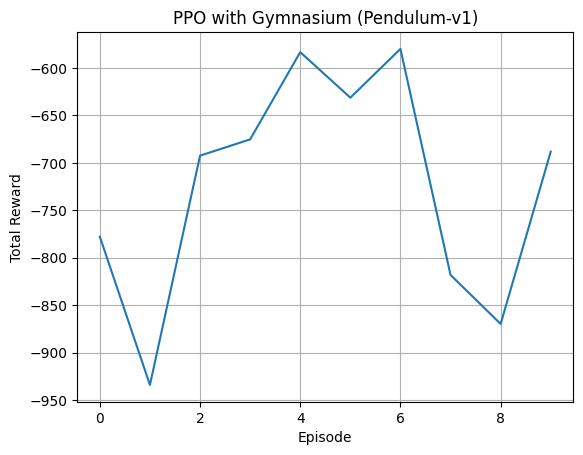

In [2]:
# Hyperparameters
EPISODES = 10
STEPS_PER_EPISODE = 100
GAMMA = 0.99
CLIP_EPS = 0.2
LR = 0.003
UPDATE_EPOCHS = 4

# Environment
env = gym.make("Pendulum-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = float(env.action_space.high[0])

# Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU()
        )
        self.mu_head = nn.Linear(32, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        self.value_head = nn.Linear(32, 1)

    def forward(self, state):
        x = self.shared(state)
        mu = self.mu_head(x)
        std = self.log_std.exp()
        value = self.value_head(x)
        return mu, std, value

    def get_action(self, state):
        mu, std, value = self.forward(state)
        dist = torch.distributions.Normal(mu, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        action_clipped = torch.clamp(action, -action_bound, action_bound)
        return action_clipped, log_prob, value

# Instantiate model and optimizer
model = ActorCritic()
optimizer = optim.Adam(model.parameters(), lr=LR)

# GAE computation
def compute_gae(rewards, values, gamma=GAMMA, lam=0.95):
    returns = []
    gae = 0
    values = values + [0]
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] - values[step]
        gae = delta + gamma * lam * gae
        returns.insert(0, gae + values[step])
    return returns

# Training loop
all_rewards = []

for episode in range(EPISODES):
    log_probs = []
    values = []
    rewards = []
    states = []
    actions = []

    state, _ = env.reset()
    total_reward = 0

    for _ in range(STEPS_PER_EPISODE):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action, log_prob, value = model.get_action(state_tensor)

        action_np = action.detach().numpy().flatten()
        next_state, reward, terminated, truncated, _ = env.step(action_np)
        done = terminated or truncated

        states.append(state_tensor.squeeze(0))
        actions.append(action.squeeze(0))
        log_probs.append(log_prob)
        values.append(value.item())
        rewards.append(float(reward))

        state = next_state
        total_reward += reward

        if done:
            break

    # GAE and return calculations
    returns = compute_gae(rewards, values)
    returns = torch.tensor(returns)
    values = torch.tensor(values)
    advantages = returns - values
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    states = torch.stack(states)
    actions = torch.stack(actions)
    old_log_probs = torch.stack(log_probs).detach()

    # PPO update
    for _ in range(UPDATE_EPOCHS):
        mu, std, new_values = model(states)
        dist = torch.distributions.Normal(mu, std)
        new_log_probs = dist.log_prob(actions).sum(dim=-1)

        ratio = torch.exp(new_log_probs - old_log_probs)
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - CLIP_EPS, 1 + CLIP_EPS) * advantages
        actor_loss = -torch.min(surr1, surr2).mean()

        critic_loss = nn.MSELoss()(new_values.squeeze(), returns)
        loss = actor_loss + 0.5 * critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    all_rewards.append(total_reward)
    print(f"Episode {episode+1}/{EPISODES}, Total Reward: {total_reward:.2f}")

# Plot rewards
plt.plot(all_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("PPO with Gymnasium (Pendulum-v1)")
plt.grid(True)
plt.show()
